In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fakescorr import fakescorr, find_nearest
%matplotlib inline
from matplotlib import rc, rcParams
rcParams.update({'font.size':12})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def recovery(fakes, ID, save=False, figure=False):
    f = fakes.copy()
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_fake')[(f.ed_fake < 1e6) & (f.ed_ratio < 1.2)]
    
    lmax = np.log10(f.ed_fake.max())
    lmin = np.log10(f.ed_fake.min())
    bins = np.power(10,np.linspace(lmin,lmax,f.shape[0]/100))
    m = pd.DataFrame()
    f['range1'], bins = pd.cut(f.ed_fake, bins, retbins=True,include_lowest=True)
    m['mean_ed_fake'] = f.groupby('range1').ed_fake.mean()
    m['mean_rec_fake'] = f.groupby('range1').rec_fake.mean()
    m['std_rec_fake'] = f.groupby('range1').rec_fake.std()
    m = m.dropna(how='any')
    if figure == True:
        m.plot(x='mean_ed_fake', y='mean_rec_fake', yerr='std_rec_fake',loglog=True,
          label=('recovery rate'))
    threshold = m.mean_ed_fake[m.mean_rec_fake == find_nearest(m.mean_rec_fake.tolist(), 0.2)[0]].tolist()[0]
    return  threshold, m

def EDratio(fakes, ID, save=False, figure=False):
    f = fakes[fakes.rec_fake!=0.]
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_ratio')
    f = f[f.ed_ratio<1.5]
    if figure==True:
        plt.figure(figsize=(7,5))
        plt.scatter(f.ed_rec,f.ed_ratio,s=f.ed_rec_err/f.ed_rec*1e3, alpha=0.5,color='k',
                    label='$\sigma_{ED}/ED$')
        plt.axhline(y=1.,color='r')
        plt.axhline(y=1.1,color='r',linestyle='dashed')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim((0.1,1.5))
        plt.xlim((1,1e6))
        plt.xlabel('recovered ED (s)')
        plt.ylabel('recovered ratio of injected ED')
        plt.title('EPIC {}'.format(ID))
        plt.legend(loc=4, frameon=False)
    if save == True:
        plt.savefig('stars_shortlist/share/corrected/ed_ratio_{}.png'.format(ID),
                    dpi=300)
    return 



In [45]:
test = 'run_05'
Cs = ['Pleiades','M44','M67']
Tlims = [(3000.0,3249.0,'red'),(3250.0,3499.0,'orange'),
         (3500.0,3749.0,'green'),(3750.0,4000.0,'c'),(3000.0,7000.0,'black')]
threshs = pd.DataFrame(Tlims,columns=['Tmin','Tmax','color'])
for cl in Cs:
    params = pd.read_csv('stars_shortlist/{0}/{0}_parameter.csv'.format(cl))
    if cl not in threshs.columns:
        threshs[cl]=np.nan
    for Tmin,Tmax,color in Tlims:
        Tb = params[(params['T'] <= Tmax) & (params['T'] >= Tmin)]

        Ethresh = Tb.thresh20p*Tb.L_quiet
        threshs[cl][(threshs.Tmin==Tmin) & (threshs.Tmax==Tmax)] = Ethresh.median()
threshs.to_csv('stars_shortlist/share/{}_median_detection_thresholds.csv'.format(test))
threshs

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.2343776486636319e+32 4.009543006740184e+33
1.7262338415391115e+32 1.5615779822979037e+34
1.8459308318630368e+32 3.992002058304531e+33
2.4358078513825543e+32 2.1904812042451434e+32
1.768140957422684e+32 1.2914630793262393e+35


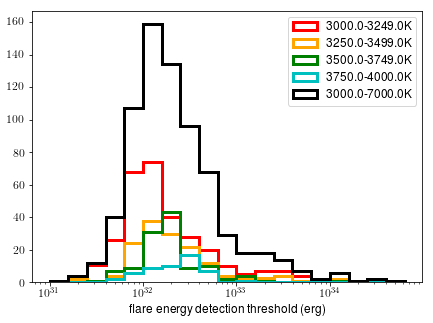

In [61]:
cluster = 'Pleiades'
test = 'run_05'
c = '04'
params = pd.read_csv('stars_shortlist/{0}/{0}_parameter.csv'.format(cluster))
plt.figure(figsize=(7,5))
for Tmin,Tmax,color in Tlims:
    Tb = params[(params['T'] <= Tmax) & (params['T'] >= Tmin)]

    Ethresh = Tb.thresh20p*Tb.L_quiet
    if Ethresh.shape[0]!=0:
        Ethresh.hist(bins=np.power(10,np.arange(31,35,0.2)),histtype='step',
                 color=color,linewidth=3,grid=False,label='{}-{}K'.format(Tmin,Tmax))
    plt.xscale('log')
    plt.xlabel('flare energy detection threshold (erg)')
    plt.legend()
    plt.savefig('stars_shortlist/share/{}_{}_median_detection_thresholds.png'.format(test,cluster))
    print(Ethresh.median(),Ethresh.std())

In [35]:
#snippet to calculate thresholds initially: DO NOT USE!
for ID in oid_list:
    try:
        #path = 'stars_shortlist/{}/results/{}/fakes/{}_k2sc_allfakes.csv'.format(cluster,test,ID)
        path = '/home/eilin/research/k2_cluster_flares/aprun/k2sc_{}/{}-c{}_kepler_v2_lc.fits_all_fakes.csv'.format(test[-2:],ID,c)
        df = pd.read_csv(path)
        threshold, m = recovery(df,ID)
        if 'thresh20p' not in params.columns:
            params['thresh20p'] = np.nan
        params['thresh20p'][params.EPIC==ID] = threshold
    except (FileNotFoundError, OSError):
        print('OF')
        continue

/home/eilin/.local/lib/python3.4/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
